In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from pyldl.algorithms import LDL_LRR
from pyldl.utils import LDLEarlyStopping
from pyldl.metrics import score, euclidean
from pyldl.algorithms.base import BaseGD, BaseDeepLDL
import pyldl.applications.facial_emotion_recognition as fer

In [4]:
import keras
import tensorflow as tf

In [5]:
X, y = fer.load_jaffe('./jaffe/')

In [6]:
train, test = train_test_split(np.arange(X.shape[0]), test_size=0.1, random_state=0)
val = int(train.shape[0] * 0.9)

In [7]:
class LRR(BaseGD, BaseDeepLDL):
    @staticmethod
    def loss_function(y, y_pred):
        return tf.math.reduce_mean(keras.losses.kl_divergence(y, y_pred))

    def _loss(self, X, y, start, end):
        y_pred = self._call(X)
        kld = self.loss_function(y, y_pred)
        rnk = LDL_LRR.ranking_loss(y_pred, self._P[start:end], self._W[start:end]) / (2 * X.shape[0])
        return kld + self._alpha * rnk

    def _before_train(self):
        self._P, self._W = LDL_LRR.preprocessing(self._y)

    def fit(self, X, y, alpha=1e-2, **kwargs):
        self._alpha = alpha
        return super().fit(X, y, **kwargs)

In [8]:
lrr = LRR()

In [9]:
inputs = keras.Input(shape=X.shape[1:])
encodes = keras.applications.ResNet50(include_top=False, weights='imagenet')(inputs)
pooling = keras.layers.GlobalAveragePooling2D()(encodes)
outputs = keras.layers.Dense(y.shape[1], activation='softmax')(pooling)

In [10]:
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
lrr.fit(X[train][:val], y[train][:val], verbose=1,
        batch_size=32, optimizer=keras.optimizers.SGD(2e-3), model=model, X_val=X[train][val:], y_val=y[train][val:],
        callbacks=[LDLEarlyStopping(monitor='kl_divergence', patience=50)]);

 192/1000 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - loss: 0.0360 - kl_divergence: 0.0360 
Epoch 192: early stopping (best kl_divergence: 0.030358654506513753).


In [12]:
metrics=["chebyshev", "clark", "canberra", "kl_divergence", "cosine", "intersection"]

In [13]:
y_pred = lrr.predict(X[test])
print(pd.Series(score(y[test], y_pred, metrics=metrics), index=metrics))

chebyshev        0.065661
clark            0.251079
canberra         0.524503
kl_divergence    0.026923
cosine           0.974960
intersection     0.912017
dtype: float64


In [14]:
df = pd.DataFrame({'score': euclidean(y[test], y_pred, reduction=None),
                   'group': y[test].argmax(axis=1)})
samples = df.groupby('group')['score'].idxmin().values

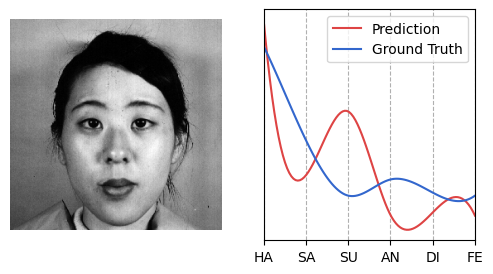

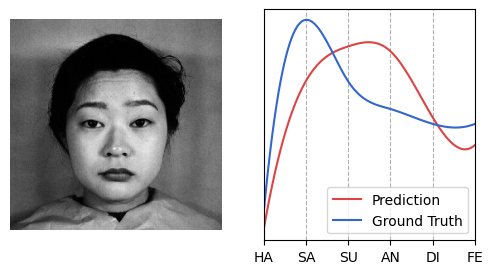

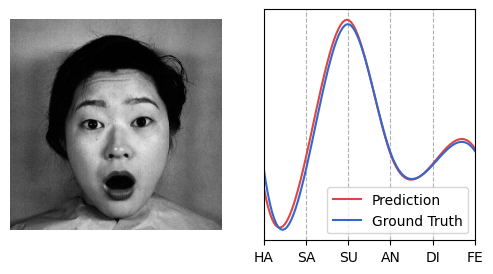

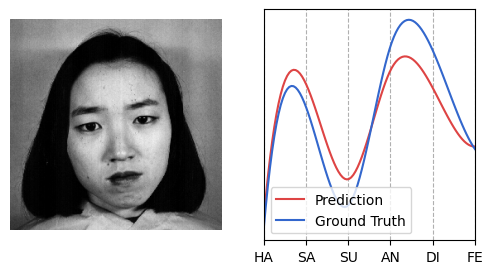

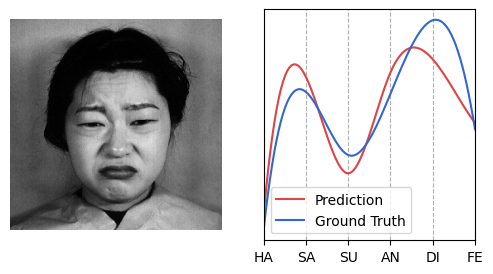

In [15]:
for i in samples:
    fer.visualization(X[test][i], y_pred[i], y[test][i])

In [16]:
# Windows
# fer.extract_ck_plus('./CK+/', './CK+/features/', './OpenFace_2.2.0_win_x64/')

In [17]:
X, labels, fps, aus = fer.load_ck_plus('./CK+/', './CK+/features/')

In [18]:
y = keras.utils.to_categorical(labels)

In [19]:
train, test = train_test_split(np.arange(X.shape[0]), test_size=0.1, random_state=0)

In [20]:
val = int(train.shape[0] * 0.9)

In [21]:
alsg = fer.LDL_ALSG()

In [22]:
alsg.fit(X[train][:val], y[train][:val], fps, aus, verbose=1,
         batch_size=32, optimizer=keras.optimizers.SGD(1e-4),
         X_val=X[train][val:], y_val=y[train][val:], callbacks=[LDLEarlyStopping(monitor='loss', patience=50)]);

  74/1000 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - loss: 9.6527 
Epoch 74: early stopping (best loss: 8.084104537963867).


In [23]:
metrics=["zero_one_loss"]

In [24]:
y_pred = alsg.predict_proba(X[test])
print(pd.Series(score(y[test], y_pred, metrics=metrics), index=metrics))

zero_one_loss    0.258065
dtype: float64


In [25]:
df = pd.DataFrame({'score': euclidean(y[test], y_pred, reduction=None),
                   'group': y[test].argmax(axis=1)})
samples = df.groupby('group')['score'].idxmin().values

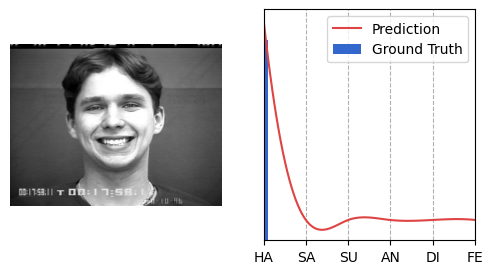

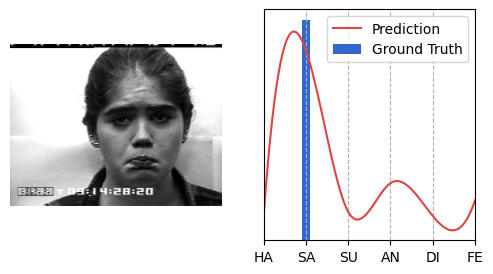

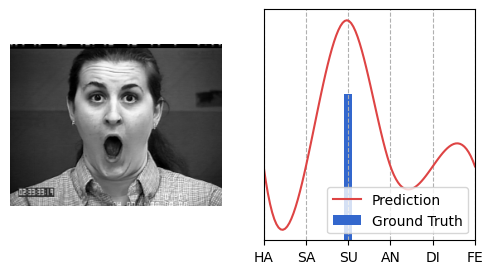

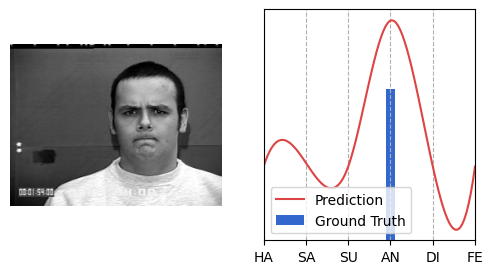

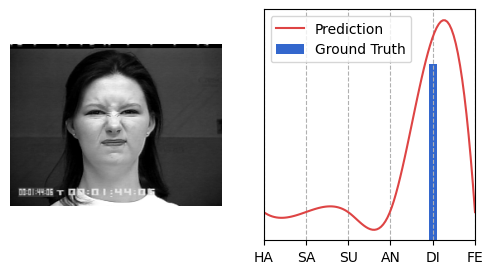

In [26]:
for i in samples:
    fer.visualization(X[test][i], y_pred[i], y[test][i], style_real='binary')